# Cat vs Dog Classification Using Transfer Learning (VGG16)

Author: Bo Fu  
[LinkedIn](https://www.linkedin.com/in/bofu/)  
Completed: June 2025

---

### Project Objective

This notebook explores the application of transfer learning to solve a binary image classification problem: distinguishing between cats and dogs.

By utilizing a pretrained convolutional neural network, high accuracy is achieved using fewer training samples, fewer epochs, and significantly less computational effort than when training CNNs from scratch.

A VGG16 model pretrained on ImageNet is used as a fixed feature extractor. Two fully-connected classifiers—simple and complex—are trained on top of these extracted features to assess the performance trade-offs between model complexity and accuracy.

---

### Dataset Overview

The dataset originates from the [Kaggle Dogs vs. Cats competition](https://www.kaggle.com/competitions/dogs-vs-cats/data), comprising 25,000 labeled images (12,500 per class) in JPEG format.

To reduce computational overhead and emphasize the efficiency of transfer learning, a representative subset of 20,000 images was selected:

- 10,000 cat images: cat.0.jpg to cat.9999.jpg → stored in `data/cats/`
- 10,000 dog images: dog.0.jpg to dog.9999.jpg → stored in `data/dogs/`

---

### Dataset Splitting

After feature extraction with VGG16, the dataset was randomly partitioned into three subsets:

- Training set: 70%  
- Validation set: 15%  
- Test set: 15%

---

### Project Structure: Modular Design

This project adopts a modular architecture for clarity, scalability, and ease of reuse. All key functionalities are encapsulated within independent Python modules located in `./modules/`:

- `feature_extraction.py`: loads or extracts image features using VGG16
- `build_model.py`: defines both simple and complex fully-connected classifiers
- `callbacks.py`: configures training callbacks (e.g., EarlyStopping)
- `train_utils.py`: manages model training, saving, and history persistence
- `evaluate_model.py`: computes evaluation metrics and visualizes classification
- `history_plot.py`: plots training and validation performance curves
- `visualize_errors.py`: displays misclassified images for qualitative analysis

> *Modularization supports cleaner experimentation, easier debugging, and faster iteration—key attributes for any robust machine learning workflow.*

---


### Why Transfer Learning?

Training CNNs from scratch is computationally expensive and typically requires large-scale labeled datasets. Transfer learning addresses these challenges by leveraging representations learned on large datasets (e.g., ImageNet) and adapting them to new tasks.

Benefits include:

- Eliminates the need to relearn low-level features (edges, textures)
- Reduces risk of overfitting, especially on small datasets
- Accelerates training and stabilizes convergence
- Delivers strong results with minimal parameter tuning

---

### Comparative Perspective

In [a previous project](https://github.com/BoFu001/Catdog-cnn-from-scratch), custom CNNs were trained from scratch using different image resolutions and data augmentation strategies. The best-performing model (Model No. 13) achieved:

- F1-score: 94.9%
- Cost: High training time and data requirement

In this notebook, using VGG16 as a fixed feature extractor, a simple fully-connected model achieves:

- F1-score: 98.29%
- With: 10,000 images per class, fewer epochs, and minimal tuning

---

### Summary

This project demonstrates that even lightweight classifiers can achieve state-of-the-art results when powered by strong pretrained features. Transfer learning not only improves performance but also significantly reduces the cost of model development.

> *Takeaway: Transfer learning is a powerful and efficient paradigm for real-world image classification tasks with limited data and compute resources.*

In [4]:
# Built-in
import random
import sys
import os

# Add custom module path before custom imports
sys.path.append("./modules")

# Third-party
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Custom modules
from feature_extraction import get_features
from build_model import build_fc_model_simple, build_fc_model_complex
from evaluate_model import evaluate_classification
from callbacks import get_callbacks
from history_plot import plot_history
from train_utils import get_model_and_history
from visualize_errors import show_misclassified_images

In [5]:
# Set data and model paths based on environment
LOCAL = 1
KAGGLE = 2
environment = LOCAL  # Change to KAGGLE when running on Kaggle

# Define paths
if environment == LOCAL:
    data_dir = "./data"
    model_dir = "./models"
elif environment == KAGGLE:
    data_dir = "/kaggle/working/data"
    model_dir = "/kaggle/working"

In [6]:
# Hyperparameters & Global Settings
SEED = 123
EPOCHS = 50
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224) # Input size required by VGG16
SUPPORTED_EXTS = [".jpg", ".jpeg", ".png"]

# Set global random seed for reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [7]:
# Scan class folders
class_names = sorted([
    name for name in os.listdir(data_dir)

    # Scan class folders only, ignoring system files like .DS_Store and .gitkeep
    if os.path.isdir(os.path.join(data_dir, name)) and not name.startswith('.')
])

# Map class names to integer labels
label_map = {cls: idx for idx, cls in enumerate(class_names)}
print(label_map)

{'cats': 0, 'dogs': 1}


In [8]:
# Load pretrained VGG16 (no top)
model_vgg = VGG16(weights='imagenet', include_top=False)

In [9]:
# Load or extract features, labels, and image paths
FEATURE_PATH = os.path.join(model_dir, "features.npy")
LABEL_PATH = os.path.join(model_dir, "labels.npy")
PATH_PATH = os.path.join(model_dir, "image_paths.npy")

X, y_raw, image_paths = get_features(
    model=model_vgg,
    feature_path=FEATURE_PATH,
    label_path=LABEL_PATH,
    path_path=PATH_PATH,
    data_dir=data_dir,
    class_names=class_names,
    supported_exts=SUPPORTED_EXTS,
    image_size=IMAGE_SIZE
)

# Convert string labels to integer indices
y = np.array([label_map[label.item()] for label in y_raw]).reshape(-1, 1)

Loading features from:
./models/features.npy
./models/labels.npy
./models/image_paths.npy


In [10]:
# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Split features, labels, and image paths into Train / Validation / Test
X_train, X_temp, y_train, y_temp, paths_train, paths_temp = train_test_split(
    X_scaled, y, image_paths, test_size=0.3, random_state=SEED
)

X_val, X_test, y_val, y_test, paths_val, paths_test = train_test_split(
    X_temp, y_temp, paths_temp, test_size=0.5, random_state=SEED
)

In [12]:
# Train Simple Model
model_name = "simple_model.keras"
history_name = "simple_model_history.pkl"
simple_model_path = os.path.join(model_dir, model_name)

# Callback functions
callbacks_simple = get_callbacks(filepath=simple_model_path)

# Get model and training history (automatically loads if exists, or trains and saves)
model_simple, history_simple = get_model_and_history(
    model_dir=model_dir,
    model_name=model_name,
    history_name=history_name,
    train_data=(X_train, y_train),
    val_data=(X_val, y_val),
    input_shape=X.shape[1],
    create_model_fn=build_fc_model_simple,
    epochs=EPOCHS,
    callbacks = callbacks_simple
)

Found existing model at: ./models/simple_model.keras.


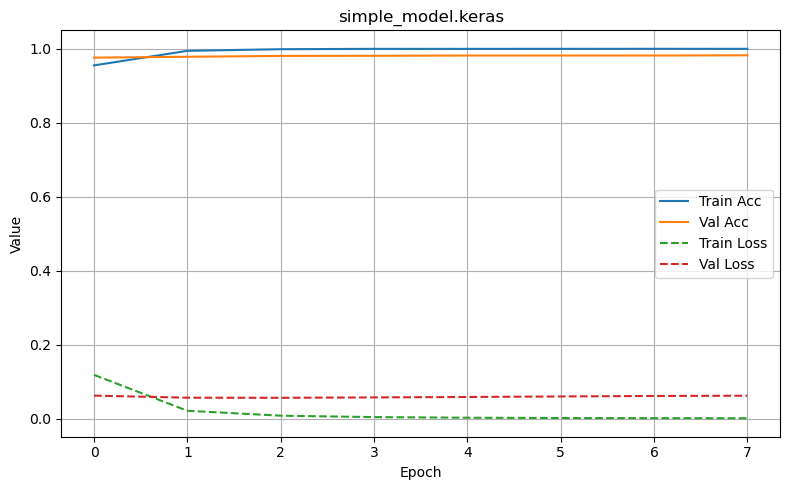

In [13]:
# Plot the training history (accuracy and loss) of the simple model
plot_history(history_simple, title=model_name)

I0000 00:00:1750325691.125514  551962 service.cc:152] XLA service 0x600003125100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750325691.125532  551962 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-06-19 17:34:51.178580: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   
Precision: 98.72%
Recall:    97.86%
F1-score:  98.29%
True cats predicted as cats: 1484
True cats predicted as dogs (FP): 19
True dogs predicted as cats (FN): 32
True dogs predicted as dogs: 1465


I0000 00:00:1750325691.359395  551962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


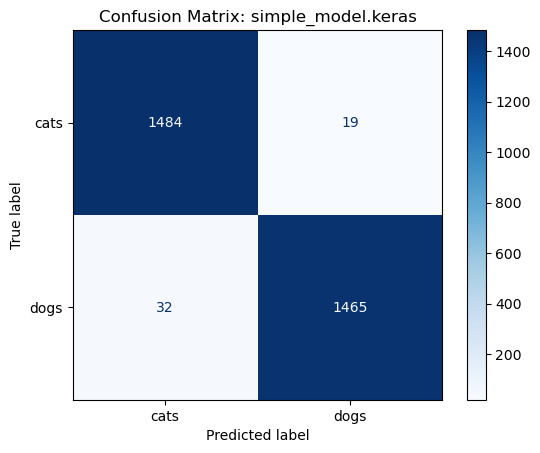

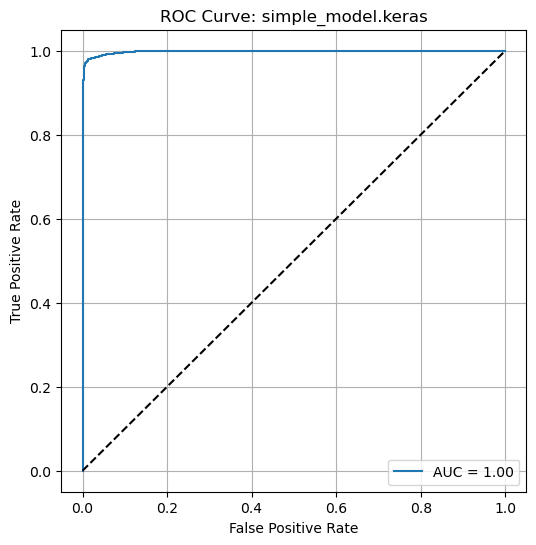

In [14]:
# Evaluate simple model
y_proba_simple = model_simple.predict(X_test)
y_pred_simple = (y_proba_simple > 0.5).astype("int32")
evaluate_classification(y_test, y_pred_simple, y_proba_simple, model_name, class_names)

[simple_model.keras] Total misclassified: 51


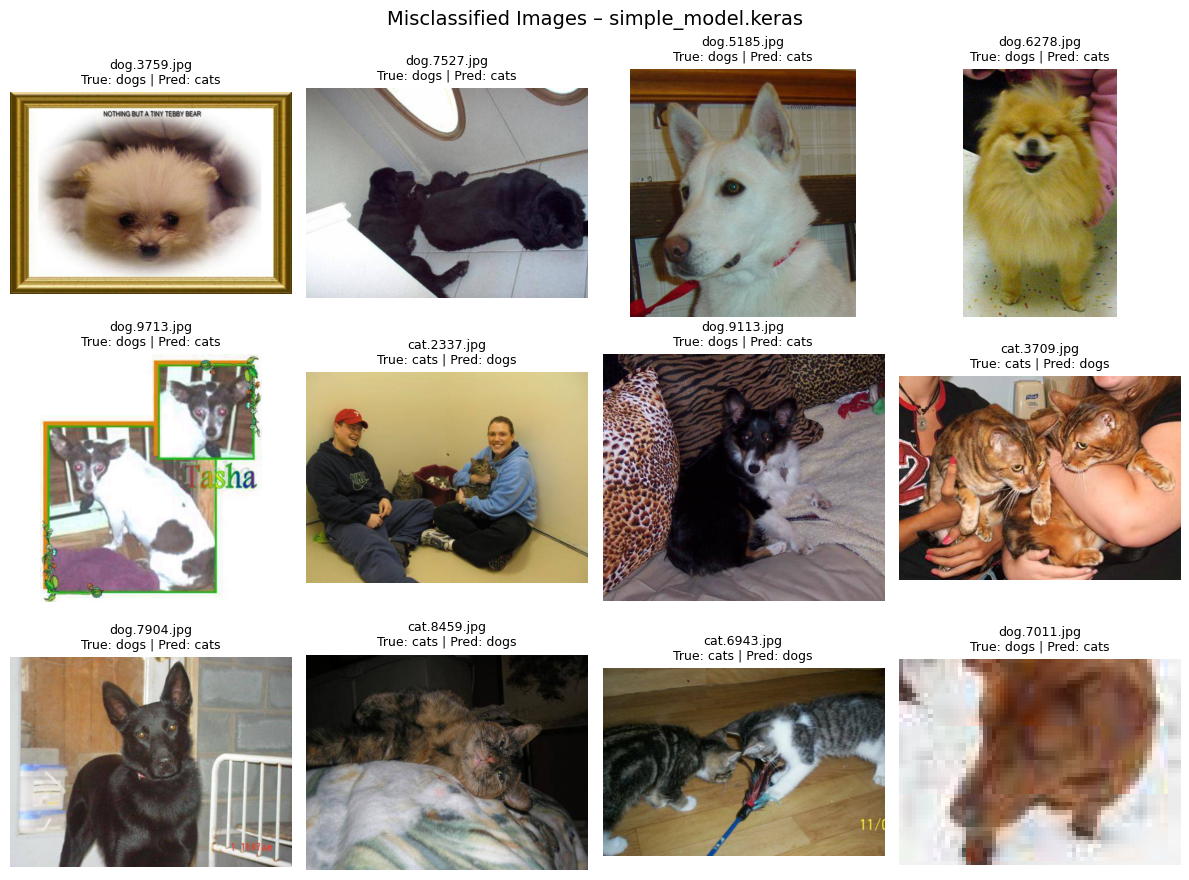

In [15]:
# Show misclassified images by simple model
show_misclassified_images(
    model_name=model_name,
    y_test=y_test,
    y_pred=y_pred_simple,
    image_paths=paths_test,
    class_names=class_names,
    max_images=12
)

In [16]:
# Train complex model
model_name = "complex_model.keras"
history_name = "complex_model_history.pkl"
complex_model_path = os.path.join(model_dir, model_name)

# Callback functions
callbacks_complex = get_callbacks(filepath=complex_model_path)

# Get model and training history (automatically loads if exists, or trains and saves)
model_complex, history_complex = get_model_and_history(
    model_dir=model_dir,
    model_name=model_name,
    history_name=history_name,
    train_data=(X_train, y_train),
    val_data=(X_val, y_val),
    input_shape=X.shape[1],
    create_model_fn=build_fc_model_complex,
    epochs=EPOCHS,
    callbacks = callbacks_complex
)

Found existing model at: ./models/complex_model.keras.


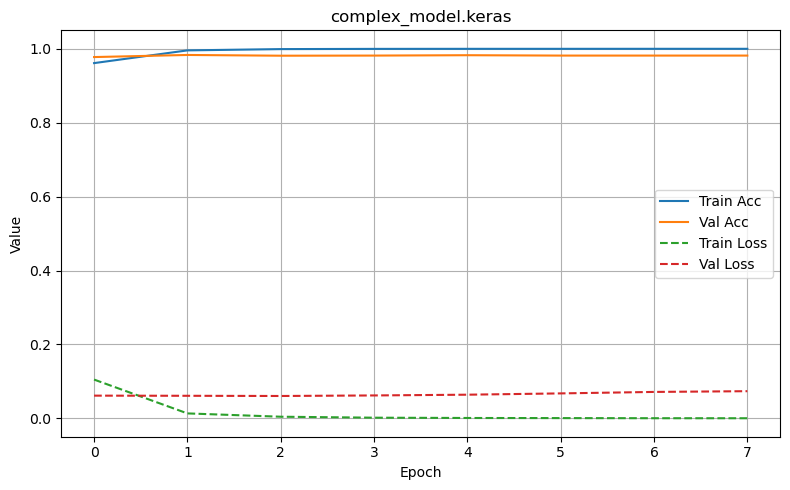

In [17]:
# Plot the training history (accuracy and loss) of the complex model
plot_history(history_complex, title=model_name)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Precision: 98.32%
Recall:    98.00%
F1-score:  98.16%
True cats predicted as cats: 1478
True cats predicted as dogs (FP): 25
True dogs predicted as cats (FN): 30
True dogs predicted as dogs: 1467


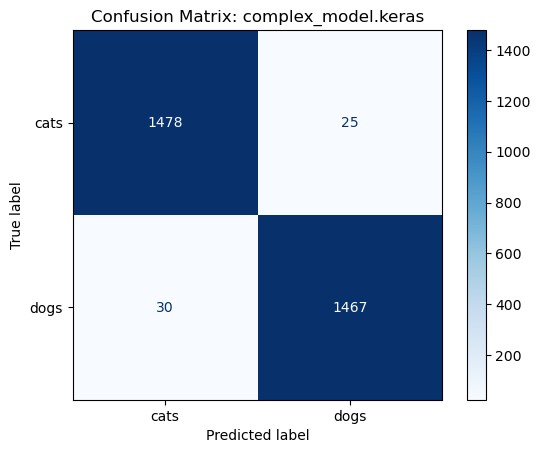

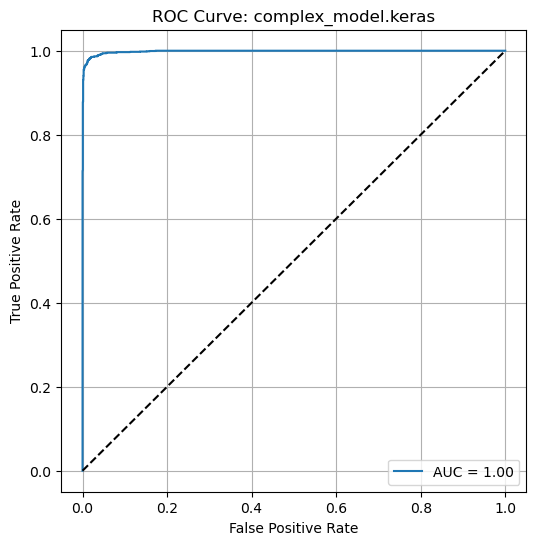

In [19]:
# Evaluate complex model
y_proba_complex = model_complex.predict(X_test)
y_pred_complex = (y_proba_complex > 0.5).astype("int32")
evaluate_classification(y_test, y_pred_complex, y_proba_complex, model_name, class_names)

[complex_model.keras] Total misclassified: 55


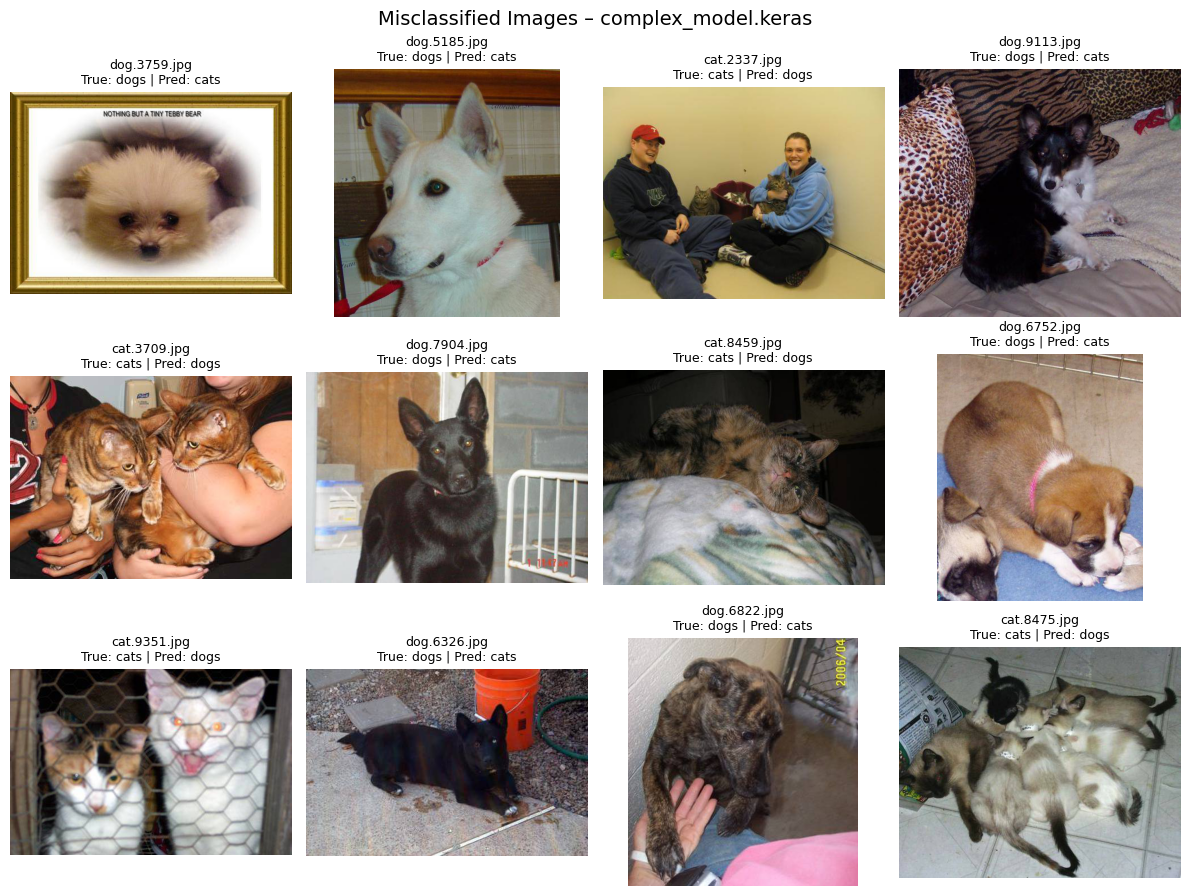

In [20]:
# Show misclassified images by complex model
show_misclassified_images(
    model_name=model_name,
    y_test=y_test,
    y_pred=y_pred_complex,
    image_paths=paths_test,
    class_names=class_names,
    max_images=12
)

## Model Evaluation Summary: Simple vs. Complex Classifier (VGG16 Features)

This section presents a detailed comparison of two fully-connected classifiers—Simple and Complex—trained on top of VGG16-extracted features for binary classification of cat and dog images.

---

### Simple Model Performance

| Metric        | Value      |
|---------------|------------|
| Precision     | 98.72%     |
| Recall        | 97.86%     |
| F1-score      | 98.29%     |
| True Cats → Cats (TN) | 1484 |
| True Cats → Dogs (FP) | 19   |
| True Dogs → Cats (FN) | 32   |
| True Dogs → Dogs (TP) | 1465 |

#### Key Observations:
- High precision indicates very few false positives—cats wrongly predicted as dogs.
- Slightly lower recall suggests some dogs were missed (classified as cats).
- Overall, the model performs exceptionally well with minimal architecture.

---

### Complex Model Performance

| Metric        | Value      |
|---------------|------------|
| Precision     | 98.32%     |
| Recall        | 98.00%     |
| F1-score      | 98.16%     |
| True Cats → Cats (TN) | 1478 |
| True Cats → Dogs (FP) | 25   |
| True Dogs → Cats (FN) | 30   |
| True Dogs → Dogs (TP) | 1467 |

#### Key Observations:
- Slightly improved recall compared to the simple model, reducing false negatives.
- Precision drops slightly due to an increase in false positives.
- Includes dropout regularization and more hidden units, which may improve generalization slightly.

---

### Comparative Analysis

| Metric                                 | Simple Model                  | Complex Model                         |
|----------------------------------------|-------------------------------|----------------------------------------|
| **Precision**                          | **98.72%**                    | 98.32%                                 |
| **Recall**                             | 97.86%                        | **98.00%**                             |
| **F1-score**                           | **98.29%**                    | 98.16%                                 |
| **False Positives (Cats → Dogs)**      | 19                            | 25                                     |
| **False Negatives (Dogs → Cats)**      | 32                            | 30                                     |
| **Dense Layers (incl. output)**        | 2                             | 2                                      |
| **Hidden Units**                       | 10                            | 256                                    |
| **Dropout**                            | No                            | Yes (0.5)                              |
| **Architecture Summary**               | Dense(10) → Dense(1)          | Dense(256) → Dropout → Dense(1)        |
| **Training Time**                      | Faster                        | Slightly longer                        |

---

### Interpretation

- Simple Model slightly outperforms in precision and F1-score, making it ideal for applications where false positives are more costly.
- Complex Model offers a marginally better recall, which may be preferable in contexts where missing a true positive (e.g., dog misclassified as cat) is more critical.
- The performance difference is minimal, suggesting that even a shallow classifier performs extremely well when backed by strong, pretrained features (VGG16).

---

### Conclusion

Both models deliver excellent performance, demonstrating the power of transfer learning:

- If the goal is to minimize compute time and complexity: Simple model is the recommended choice.
- If the task prioritizes recall or robustness against underfitting: the Complex model may offer slight advantages.

> Takeaway: Transfer learning enables high-performance image classification with compact models and minimal training—even with only 10,000 images per class.

---

### Acknowledgments & Closing Remarks

This notebook was a hands-on exploration of transfer learning applied to image classification using VGG16 as a fixed feature extractor. The results reinforce how pretrained models can dramatically reduce training costs while delivering high accuracy—even with limited data and simple classifiers.

If you found this work insightful or would like to connect, feel free to reach out.

🔗 [LinkedIn – Bo Fu](https://www.linkedin.com/in/bofu/)  
📅 Completed: June 2025

Thank you for reading!